##**x21145377_baby_recommendation_system_amazon__data_set_1_initial_Case_study_A**

## Dependencies

In [ ]:
#import libraries
import json
import numpy as np
from collections import defaultdict
import warnings
import gensim
import pandas as pd
from gensim.models.doc2vec import Doc2Vec
import numpy as np
import keras
import math
import gzip
from keras import backend as K
from keras.models import Model
from keras.layers import Embedding, Input, Dense, Flatten, Concatenate, Multiply, Lambda, Reshape
from keras.layers.core import Dropout
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
import math as mt

## Display the dataset

In [ ]:
## Convert data from gz to DataFrame
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


## Download The Review and Meta Data

In [ ]:
# Download Review Data
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Baby.json.gz

--2022-12-14 14:04:25--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Baby.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191601185 (183M) [application/x-gzip]
Saving to: ‘reviews_Baby.json.gz’

reviews_Baby.json.g 100%[===================>] 182.72M  4.34MB/s    in 34s     

2022-12-14 14:04:59 (5.45 MB/s) - ‘reviews_Baby.json.gz’ saved [191601185/191601185]



In [ ]:
# Download Meta Data
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Baby.json.gz

--2022-12-14 14:05:00--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Baby.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31328004 (30M) [application/x-gzip]
Saving to: ‘meta_Baby.json.gz’

meta_Baby.json.gz   100%[===================>]  29.88M  3.31MB/s    in 11s     

2022-12-14 14:05:11 (2.72 MB/s) - ‘meta_Baby.json.gz’ saved [31328004/31328004]



In [ ]:
#display the meta data as  dataframe
metadata = getDF('./meta_Baby.json.gz')
metadata.head()

,asin,categories,description,title,price,imUrl,brand,related,salesRank
0,0188399313,[[Baby]],Wee-Go Glass baby bottles by LifeFactory (Baby...,Lifefactory 4oz BPA Free Glass Baby Bottles - ...,69.99,http://ecx.images-amazon.com/images/I/41Swthpd...,Lifefactory,"{'also_bought': ['B002SG7K7A', 'B003CJSXW8', '...",NaN
1,0188399518,[[Baby]],The Planet Wise Flannel Wipes are 10 super sof...,Planetwise Flannel Wipes,15.95,http://ecx.images-amazon.com/images/I/41otjnA4...,Planet Wise,"{'also_bought': ['B00G96N3YY', 'B003XSEV2O', '...",NaN
2,0188399399,[[Baby]],The Planet Wise Wipe PouchTM features our pate...,Planetwise Wipe Pouch,10.95,http://ecx.images-amazon.com/images/I/61x8h9u6...,NaN,"{'also_bought': ['B005WWI0DA', 'B005WWIMGA', '...",NaN
3,0316967297,[[Baby]],Hand crafted set includes 1 full quilt (76x86 ...,Annas Dream Full Quilt with 2 Shams,109.95,http://ecx.images-amazon.com/images/I/51%2BZ1%...,NaN,"{'also_viewed': ['B009LTER3W', 'B00575TI5Q', '...",NaN
4,0615447279,[[Baby]],Thumbuddy To Love- The Binky Fairy helps child...,Stop Pacifier Sucking without tears with Thumb...,16.95,http://ecx.images-amazon.com/images/I/51RKKENl...,,"{'also_bought': ['0979670004', '1601310234', '...",NaN


In [ ]:
#display the review data as  dataframe
reviews = getDF('./reviews_Baby.json.gz')
reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A28O3NP6WR5517,0188399313,Jennifer gymer,"[0, 0]","They work very well. Easy to clean, we wash th...",5.0,These bottles are great!,1369612800,"05 27, 2013"
1,AX0M1Z6ZWO52J,0188399399,Ash M.,"[1, 1]",it came early and was not disappointed. i love...,5.0,perfect,1365465600,"04 9, 2013"
2,A1KD7N84L7NIUT,0188399518,Buffy Fan,"[0, 0]",I ended up with a variety of different brands ...,4.0,Good cotton wipes,1392336000,"02 14, 2014"
3,A29CUDEIF4X1UO,0188399518,J. D. Solbach,"[1, 1]","These flannel wipes are OK, but in my opinion ...",3.0,Sending them back.,1373241600,"07 8, 2013"
4,A32592TYN6C9EM,0316967297,Amazon Customer,"[0, 0]","Cute quilt, the colors are perfect and my litt...",4.0,Very cute,1378425600,"09 6, 2013"


In [ ]:
# extract review baby file 
!gunzip -k reviews_Baby.json.gz

In [ ]:
# extract meta baby file 
!gunzip -k meta_Baby.json.gz

In [ ]:
metadata['description'] = metadata['description'].str.lower() 

In [ ]:
reviews['reviewText']=reviews['reviewText'].str.lower()

In [ ]:
reviews.reviewText=reviews.reviewText.str.replace('[#,@,&]','')

<ipython-input-12-c4cdd1a59127>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews.reviewText=reviews.reviewText.str.replace('[#,@,&]','')


In [ ]:
metadata.description=metadata.description.str.replace('[#,@,&]','')

<ipython-input-13-f669e10c16be>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  metadata.description=metadata.description.str.replace('[#,@,&]','')


In [ ]:
metadata.head()

,asin,categories,description,title,price,imUrl,brand,related,salesRank
0,0188399313,[[Baby]],wee-go glass baby bottles by lifefactory (baby...,Lifefactory 4oz BPA Free Glass Baby Bottles - ...,69.99,http://ecx.images-amazon.com/images/I/41Swthpd...,Lifefactory,"{'also_bought': ['B002SG7K7A', 'B003CJSXW8', '...",NaN
1,0188399518,[[Baby]],the planet wise flannel wipes are 10 super sof...,Planetwise Flannel Wipes,15.95,http://ecx.images-amazon.com/images/I/41otjnA4...,Planet Wise,"{'also_bought': ['B00G96N3YY', 'B003XSEV2O', '...",NaN
2,0188399399,[[Baby]],the planet wise wipe pouchtm features our pate...,Planetwise Wipe Pouch,10.95,http://ecx.images-amazon.com/images/I/61x8h9u6...,NaN,"{'also_bought': ['B005WWI0DA', 'B005WWIMGA', '...",NaN
3,0316967297,[[Baby]],hand crafted set includes 1 full quilt (76x86 ...,Annas Dream Full Quilt with 2 Shams,109.95,http://ecx.images-amazon.com/images/I/51%2BZ1%...,NaN,"{'also_viewed': ['B009LTER3W', 'B00575TI5Q', '...",NaN
4,0615447279,[[Baby]],thumbuddy to love- the binky fairy helps child...,Stop Pacifier Sucking without tears with Thumb...,16.95,http://ecx.images-amazon.com/images/I/51RKKENl...,,"{'also_bought': ['0979670004', '1601310234', '...",NaN


In [ ]:
reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A28O3NP6WR5517,0188399313,Jennifer gymer,"[0, 0]",they work very well. easy to clean we wash the...,5.0,These bottles are great!,1369612800,"05 27, 2013"
1,AX0M1Z6ZWO52J,0188399399,Ash M.,"[1, 1]",it came early and was not disappointed. i love...,5.0,perfect,1365465600,"04 9, 2013"
2,A1KD7N84L7NIUT,0188399518,Buffy Fan,"[0, 0]",i ended up with a variety of different brands ...,4.0,Good cotton wipes,1392336000,"02 14, 2014"
3,A29CUDEIF4X1UO,0188399518,J. D. Solbach,"[1, 1]",these flannel wipes are ok but in my opinion n...,3.0,Sending them back.,1373241600,"07 8, 2013"
4,A32592TYN6C9EM,0316967297,Amazon Customer,"[0, 0]",cute quilt the colors are perfect and my littl...,4.0,Very cute,1378425600,"09 6, 2013"


## Preprocessing

In [ ]:
#Hyperparameter 
dataName =  "Baby"# name of your product
vector_size = 100 # vector size of reviewtext and item description
epoch_num = 100 # number of vector
reviews_data = [] # review list to insert review data inside
meta_data = [] # meta list to insert meta data inside
num_ui_link = 20  # the number of each user link to items
num_iu_link = 0  # the number of each item link to user

# user -> item  ->  for text
ui_dict = defaultdict(list)
#item -> user - >  for text
iu_dict = defaultdict(list)
#rating training data list
reviews_train_data = []
#rating testing data list
reviews_test_data = []
# max number of item
max_num_item = 1
# max number of users
max_num_user = 1
#item -> user -> for rating
iu_dict2 = defaultdict(list)
# user -> item  ->  for rating
ui_dict2 = defaultdict(list)
len_ui_dict = {}
split_ratio = 4 #ratio to split between test and train
epochs = 20 

In [ ]:
# Append review.json to  review_data list

with open('./reviews_' + dataName + '.json') as f:
    for line in f:
        reviews_data.append(json.loads(line))
    f.close()
   

In [ ]:
#reviews_data[:1]

```
## Output

[{'reviewerID': 'A28O3NP6WR5517',
  'asin': '0188399313',
  'reviewerName': 'Jennifer gymer',
  'helpful': [0, 0],
  'reviewText': 'They work very well. Easy to clean, we wash them in the dishwasher every day. Our LO loves to hold on to the bottle and the plastic covering makes it easy for her to hold on to.',
  'overall': 5.0,
  'summary': 'These bottles are great!',

'unixReviewTime': 1369612800,
  'reviewTime': '05 27, 2013'}]
```

In [ ]:
#showing review text for each prediction 
dis =  {}
for i in reviews_data :
    if  len(dis) == 5 :
        break
    if i["overall"] not in dis :
        dis[i["overall"]] = i["reviewText"]
        


In [ ]:
dis = dict(sorted(dis.items(),key = lambda x:x[0]))
for i,j in dis.items():
    print(i, "  " , j )
    print()

1.0    I think the papers and stickers that come w/ it are cute, but the book itself is pretty cheap looking.

2.0    I bought this with high hopes of it actually working to get my 2 year old daughter off of her pacifier. While she really likes the book, I don't think it's going to work. I went in her room in the night to deliver the pacifier fairy and take the pacifier and she woke up SCREAMING for her pacifier before I even left the room. This does not have any real support or tips for parents. We will keep reading the book and try again, but not thinking it will work for us.

3.0    These flannel wipes are OK, but in my opinion not worth keeping.  I also ordered someImse Vimse Cloth Wipes-Ocean Blue-12 countwhich are larger, had a nicer, softer texture and just seemed higher quality.  I use cloth wipes for hands and faces and have been usingThirsties 6 Pack Fab Wipes, Boyfor about 8 months now and need to replace them because they are starting to get rough and have had stink issues 

In [ ]:
# Append meta.json to meta_data list
with open('./meta_' + dataName + '.json') as f:
    for line in f:
        line_dict = json.dumps(eval(line))
        meta_data.append(json.loads(line_dict))
    f.close()

In [ ]:
#meta_data[:1]

```
[{'asin': '0188399313',
  'categories': [['Baby']],
  'description': 'Wee-Go Glass baby bottles by LifeFactory (Babylife) are designed to grow with your child. The included clear cover can also serve as an easy to hold cup. Twist on the solid cap (sold separately) and use your bottles for storing juice or snacks. Perfect for a lunchbox or traveling. The bright colored silicone sleeve (patent pending) helps to protect the bottle from breakage and provides a great gripping surface and tactile experience during feeding. The bottle and sleeve can be boiled or put in the dishwasher together. They can also go in the freezer, making breast milk storage simple.',
  'title': 'Lifefactory 4oz BPA Free Glass Baby Bottles - 4-pack-raspberry and Lilac',
  'price': 69.99,
  'imUrl': 'http://ecx.images-amazon.com/images/I/41SwthpdD9L._SX300_.jpg',
  'brand': 'Lifefactory',
  'related': {'also_bought': ['B002SG7K7A',
    'B003CJSXW8',
    'B004PW4186',
    'B002O3JH9Q',
    'B002O3NLIO',
    'B004HGSU28'],
   'also_viewed': ['B003CJSXW8',
    'B0052QOL1Q',
    'B004PW4186',
    'B00EN0OLZ8',
    'B00EN0OOQY',
    'B0049YS46K',
    'B00E64CBLM',
    'B00F9YOOS6',
    'B00AH9RPVQ',
    'B00BCU2R7G',
    'B002O3NLIO',
    'B008NZ4X2K',
    'B005NIDFEW',
    'B00DKPJCH4',
    'B00CZNGWWK',
    'B00DAKJIQ4',
    'B005CT55IQ',
    'B0049YRJM0',
    'B0071IEWD0',
    'B00E64CA68',
    'B00IUB3SKK',
    'B00A7AA6XY',
    'B001F50FFE',
    'B002HU9EO4',
    'B007HP11SQ',
    'B009WPUMX4',
    'B002O3JH9Q',
    'B00F2FT3K6',
    'B00I5CR35A',
    'B00BCTY5EK',
    'B002SG7K7A',
    'B00F2FLU2U',
    'B0062ZK0GQ',
    'B002UOFR66',
    'B0055LKQQ2',
    'B00A0FGN8I',
    'B00HMYCG2W',
    'B00DHFLUO0',
    'B0040HMPA2',
    'B00I5CT9XE',
    'B008B5MMNO',
    'B00BQYVNGO',
    'B00925WM28',
    'B00BGKC3EY',
    'B005Q3LSDO',
    'B0038JDVCE',
    'B0045I6IA4'],
   'bought_together': ['B002SG7K7A', 'B003CJSXW8'],
   'buy_after_viewing': ['B003CJSXW8',
    'B0052QOL1Q',
    'B004PW4186',
    'B002SG7K7A']}}]
   ```


In [ ]:
#fill user to item and item to user dictionaries
for line_data in reviews_data:
    user_id = line_data["reviewerID"] # extract review_id from each review in reviews_data list
    item_id = line_data["asin"]  # extract item_id from each review in reviews_data list
    ui_dict[user_id].append(item_id) # assign review_id  to  item_id in ui_dict 
    iu_dict[item_id].append(user_id) # assign item_id  to review_id   in iu_dict 
#print lenght for the two dictionaries
print("len(ui_dict)=", len(ui_dict))
print("len(iu_dict)=", len(iu_dict))

len(ui_dict)= 531890
len(iu_dict)= 64426


In [ ]:
#ui_dict >>  ex >> 'A28O3NP6WR5517': ['0188399313', 'B004I110D8', 'B006ZZSME0']

In [ ]:
#iu_dict >>  ex >> '0188399313': ['A28O3NP6WR5517']

In [ ]:
# convert review json file to txt file 
ex_data = open( './reviews_' + dataName + '.txt', "w")
for line_dict in reviews_data:
    user_id = line_dict["reviewerID"] # extract review_id from each review in reviews_data list
    item_id = line_dict["asin"] # extract item_id from each review in reviews_data list
    ui_num = len(ui_dict[user_id]) #lenght of the users for this item which gave review for
    iu_num = len(iu_dict[item_id]) # lenght of  items for each user
    if ui_num >= num_ui_link and iu_num >= num_iu_link: # check if they are greater or eual to numbers which we have mentioned before  in hyperparamter cell so we could get best performance for recommendation system before we insert to text file 
        ex_data.writelines(str(line_dict) + "\n")
        iu_dict[item_id].append(user_id)
ex_data.close()

In [ ]:
# convert meta json file to txt file 
ex_data = open('./meta_' + dataName + '.txt', "w")
for line_dict in meta_data:
    item_id = line_dict["asin"] # extract item_id from each review in reviews_data list
    if item_id in iu_dict.keys():
        iu_num = len(iu_dict[item_id])# lenght of  items for each user
        if iu_num >= num_iu_link: # check if they are greater or eual to numbers which we have mentioned before  in hyperparamter cell so we could get best performance for recommendation system before we insert to text file 
            ex_data.writelines(str(line_dict) + "\n")
ex_data.close()

In [ ]:
TaggededDocument = gensim.models.doc2vec.TaggedDocument #import  the pretrained model to turn the text to vector
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')


# turn the txt file to vector >>  stage 1  in research paper
class DoctoVec:
    # turn dictionary data to list with counter
    # give each paragraph an id_number (count)  and append in text file so we could identify each paragraph and be ready for vectoriztion 
    def get_data(dict_d):
        x_train = []
        count = 0
        for (i, text) in dict_d.items():
            word_list = text.split(' ')
            l = len(word_list)
            word_list[l - 1] = word_list[l - 1].strip()
            document = TaggededDocument(word_list, tags=[i])
            x_train.append(document)
            count += 1
        return x_train, count
   
    # train model to vector
    def train(dataName, x_train, vector_size, epoch_num,kind):
        model_dm = Doc2Vec(x_train, min_count=1, window=3, vector_size=vector_size, sample=1e-3, negative=5, workers=4)
        model_dm.train(x_train, total_examples=model_dm.corpus_count, epochs=epoch_num) #train model to turn it to vectors using pretrained model
        model_dm.save('./' + dataName + '_Model_'+ kind+"_"+ str(vector_size)) #saving model after we turn it to vector so we could use it in future
        return model_dm

    # save vectors
    #saving the vector for any text we will give to our model 
    def saveVector(dataName, model_dm, v_size, count,kind):
        out = open('./' + dataName + '.'+kind, "w", encoding='utf-8')
        for num in range(0, count):
            doc_vec = model_dm.docvecs[num]
            vec_list = str(num) + ","
            for i_doc in doc_vec:
                vec_list = vec_list + str(i_doc) + ","
            out.writelines(vec_list[:-1] + "\n")
        out.close()

In [ ]:
# read review txt file
reviews_data = []
with open('./reviews_' + dataName + '.txt') as f:
    for line in f:
        line_dict = json.dumps(eval(line))
        reviews_data.append(json.loads(line_dict))
    f.close()
    
# give unique number for each product and for each user and append the in two different dictioary
asin2itemNum = {}
reviewerID2userNum = {}
num = 1
for ui in reviews_data:
    if ui["asin"] not in asin2itemNum:
        asin2itemNum[ui["asin"]] = num
        num += 1
num = 1
for uu in reviews_data:
    if uu["reviewerID"] not in reviewerID2userNum:
        reviewerID2userNum[uu["reviewerID"]] = num
        num += 1

In [ ]:
#reviewerID2userNum

In [ ]:
# loading the dictionary of UserId_ItemID_Num
def loading_metadata():
    data = []
    dict_d = {}
    with open( './meta_' + dataName + '.txt') as f:
        for line in f:
            line_dict = json.dumps(eval(line))
            data.append(json.loads(line_dict))
        for d_item in data:
            k = asin2itemNum.get(d_item["asin"])
            if "description" in d_item.keys():
                dict_d[k] = d_item["description"].replace("\n", "")
            else:
                dict_d[k] = ""
        return dict_d

In [ ]:
# turn item text to a vedcor with size of 100  and save it
dict_i = loading_metadata()
x_train_item, count_item = DoctoVec.get_data(dict_i)
model_dm = DoctoVec.train(dataName, x_train_item, vector_size, epoch_num,"item")
DoctoVec.saveVector(dataName, model_dm, vector_size, count_item,"item")
print("Item Vector Finished")

Item Vector Finished


In [ ]:
def loading_reviewdata():
    # loading the dictionary of UserId_ItemID_Num
    data = []
    dict_d = {}
    with open('./reviews_' + dataName + '.txt') as f:
        for line in f:
            line_dict = json.dumps(eval(line))
            data.append(json.loads(line_dict))
        for d_item in data:
            k = reviewerID2userNum.get(d_item["reviewerID"])
            #print(k)
            if "reviewText" in d_item.keys():
                dict_d[k] = d_item["reviewText"].replace("\n", "")
            else:
                dict_d[k] = ""
            #print(dict_d[k])
        return dict_d



```
#output example
1
I ended up with a variety of different brands of cotton flannel baby wipes.  These are good quality, just not my personal favorite.  However, if the colors really do it for you, go ahead and stock up on these, they're good.  And really, we're talking squares of flannel, it's not critical.  For what it's worth, I like BumGenius wipes best for absorbency - like wiping up spit-up.  They're thick and soft.  I like OsoCozy best for cleaning baby bums, because they're thin, the better to clean crevices with.  ALL the wipes I bought shrank a lot in the first wash (hot), so expect that.I avoided GroVia for being synthetic, but in retrospect that might have been the way to go.  I have all BumGenius 4.0 diapers, which shouldn't be washed with natural fibers.  Now I have to wash the cotton wipes with baby's clothes, rather than with the diapers, which isn't ideal.
```

In [ ]:
# turn review text to a vedcor with size of 100  and save it
dict_u = loading_reviewdata()
x_train_user, count_user = DoctoVec.get_data(dict_u)
model_dm = DoctoVec.train(dataName, x_train_user, vector_size, epoch_num,"user")
DoctoVec.saveVector(dataName, model_dm, vector_size, count_user,"user")
print("User Vector Finished")

User Vector Finished


## User Rating Input

In [ ]:
#extract the rating for each review and assign them to the product_id with the review_id
for d in reviews_data:
    user_id = reviewerID2userNum.get(d["reviewerID"])
    item_id = asin2itemNum.get(d["asin"])
    if user_id not in ui_dict2:
        ui_dict2[user_id] = list()
        if int(user_id) > max_num_user: 
            max_num_user = int(user_id)
    ui_dict2[user_id].append(item_id)
    if item_id not in iu_dict2:
        iu_dict2[item_id] = list()
        if int(item_id) > max_num_item:
            max_num_item = int(item_id)
    iu_dict2[item_id].append(user_id)

In [ ]:
for l_d in reviews_data:
    u_id = reviewerID2userNum.get(l_d["reviewerID"])
    len_ui_dict[u_id] = len(ui_dict2.get(u_id))
print("max_num_user =  " ,max_num_user)
print("max_num_item = ",max_num_item)


max_num_user =   1100
max_num_item =  10458


In [ ]:
# reviews_train_data vs reviews_test_data
#split our dataset to train and test for rating and append them to different lists
num = 0
for l_d in reviews_data:
    if num % (split_ratio + 1) < split_ratio:
        reviews_train_data.append(l_d)
        num += 1
    else:
        reviews_test_data.append(l_d)
        num += 1

In [ ]:
# insert Rating in train file
train_list = []
train_data = open('./' + dataName + ".train.rating", "w")
for l_train in reviews_train_data:
        user_id = reviewerID2userNum.get(l_train["reviewerID"])
        item_id = asin2itemNum.get(l_train["asin"])
        rating_score = int(l_train["overall"])
        str_line = str(user_id) + "  " + str(item_id) + "  " + str(rating_score)
        train_data.writelines(str_line + "\n")
        train_list.append(str_line)
train_data.close()
print("Training Rating Finished")

Training Rating Finished


In [ ]:
train_list[:1]

['1  1  4']

In [ ]:
# Insert Rating in test file
test_list = []
test_data = open('./'  + dataName + ".test.rating", "w")
for l_test in reviews_test_data:
        user_id = reviewerID2userNum.get(l_test["reviewerID"])
        item_id = asin2itemNum.get(l_test["asin"])
        rating_score = int(l_test["overall"])
        str_line = str(user_id) + "  " + str(item_id) + "  " + str(rating_score)
        test_data.writelines(str_line + "\n")
        test_list.append(str_line)
test_data.close()
print("Test Rating Finished")

Test Rating Finished


In [ ]:
test_list[:1]

['5  5  5']

In [ ]:
# Read .rating file and Return dok matrix (sparse matrix ).
# The first line of .rating file is: num_users > num_items > rating 
def get_max_users_max_items(filename):
    # Get number of users and items
    num_users, num_items = 0, 0
    with open(filename, "r") as f:
            line = f.readline()
            #print(line)
            while line is not None and line != "":
                arr = line.split("  ")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
                #print(line)
                
    return num_users , num_items


In [ ]:
# Construct  sparse matrix with size of maxmuim of users and items
def load_rating_file_as_matrix(filename):
        num_users , num_items = get_max_users_max_items(filename)
        #print(num_users , num_items)
        mat = sp.dok_matrix((num_users + 1, num_items + 1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line is not None and line != "":
                arr = line.split("  ")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if rating > 0:
                    mat[user, item] = rating
                line = f.readline()
        return mat

## Sparse Matrix : 

**A matrix is a two-dimensional data object made of m rows and n columns, therefore having total m x n values. If most of the elements of the matrix have 0 value, then it is called a sparse matrix.**

![IMAGE](https://res.cloudinary.com/practicaldev/image/fetch/s--v5V9UbEm--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://files.ai-pool.com/a/8ccc261ef0bb339e4f923b22ab06a42c.png)

In [ ]:
#display  test rating 
#mat = load_rating_file_as_matrix("./Baby.test.rating")
#print(mat)

```
 >>  output example
 (5, 5)	5.0
  (10, 5)	5.0
  (15, 5)	5.0
  (18, 8)	5.0
  (7, 13)	3.0
  (28, 13)	4.0
  (33, 13)	5.0
  (37, 15)	3.0
  (41, 17)	5.0
  (46, 17)	4.0
  (35, 18)	5.0
  (55, 18)	1.0
  (35, 19)	5.0
  (63, 22)	2.0
  (67, 23)	4.0
  (71, 23)	4.0
  (74, 26)	5.0
  (79, 29)	2.0
  (83, 31)	5.0
  .
  .
  .
  .
  .
```

In [ ]:
# get the  text vector for  user_review and item_description 
def load_review_feature(filename):
        dict = {}
        with open(filename, "r") as f:
            line = f.readline()
            while line is not None and line != "":
                fea = line.strip('\n').split(',')
                index = int(fea[0])
                if index not in dict:
                    dict[index] = fea[1:]
                line = f.readline()
        return dict

In [ ]:
#display  user_review
#dict = load_review_feature("./Baby.user")
#print(dict[0]) >>  you can change any number of user

```
['-0.0052308156', '-0.0059791277', '-0.009880755', '0.008552845', '0.003566115', '0.00026303052', '-0.009880628', '-0.00516665', '-0.009717963', '0.0020107795', '0.0028303098', '0.004643555', '-0.0042972756', '-0.0031457066', '-0.0030787874', '-0.008721917', '0.002172482', '0.009225621', '-0.009501867', '-0.0034580873', '-0.0037699104', '0.0026073814', '-0.0056915567', '0.0026206803', '0.0058025215', '-0.008106861', '-0.008329792', '-0.0099546695', '0.004933045', '-0.009122307', '0.0058419635', '0.0068002627', '-0.0065064', '-0.004519882', '-0.0012548614', '0.0016463208', '-0.0014813376', '-0.008542542', '-0.0036026144', '0.0017316246', '-0.0020569204', '-0.0072300434', '0.004184599', '-0.0085743405', '0.0027115368', '-0.0046137213', '0.00064542773', '-0.0020573472', '0.0054132272', '-0.008002572', '-0.002119851', '-9.581566e-05', '-0.0066387774', '-0.006526165', '-0.0019329595', '0.008803475', '-0.0012631703', '0.0035359787', '-0.005750313', '0.0088148145', '0.0029154683', '0.009279685', '0.004349854', '-0.004199569', '0.0022419048', '-0.0044124555', '0.0057769394', '0.001831522', '-0.002278762', '-0.0058811186', '-0.008027084', '-0.0008530736', '-0.008939364', '-0.009223635', '-0.0079399105', '0.0021690726', '-0.0065009403', '-0.0077883434', '0.0021311664', '0.0020526624', '0.008348355', '0.004667914', '-0.009410105', '-0.00033878087', '0.007854028', '0.0026714755', '0.0026803636', '-0.004883711', '0.0064671705', '0.0016488147', '-0.007602146', '0.006863971', '-0.009769399', '-0.008158595', '-0.004874165', '0.0099376775', '0.003113091', '-0.0020120381', '0.008895168', '0.0023512554']
```

In [ ]:
# get read all files we have saved in previous stage
path = './' + dataName
trainMatrix = load_rating_file_as_matrix(path + ".train.rating")
user_review_fea = load_review_feature(path + ".user")
item_review_fea = load_review_feature(path + ".item")
testRatings = load_rating_file_as_matrix(path + ".test.rating")
num_users,num_items = trainMatrix.shape


In [ ]:
num_users,num_items

(1101, 10459)

## Build Model

In [ ]:
#build model
#Intiliaze the model input
user_input = Input(shape=(1,), dtype='int32', name='user_input')
user_sent = Input(shape=(vector_size,), dtype='float32', name='user_sentiment')
item_input = Input(shape=(1,), dtype='int32', name='item_input')
item_cont = Input(shape=(vector_size,), dtype='float32', name='item_content')

#Embedding layer for user
Embedding_User = Embedding(input_dim=num_users,
                               input_length=1,
                               output_dim=vector_size,
                               name='user_embedding')

#Embedding layer for item
Embedding_Item = Embedding(input_dim=num_items,
                               input_length=1,
                               output_dim=vector_size,
                               name='item_embedding')



In [ ]:
# User Sentiment Dense Network
def user_Sentiment(user_latent, user_sent):
    latent_size = user_latent.shape[1]
    inputs = user_sent
    layer = Dense(latent_size,activation='relu',name='user_attention_layer')(inputs)
    sent = Lambda(lambda x: K.softmax(x), name='user_Sentiment_softmax')(layer)
    output = Multiply()([user_latent, sent])
    return output

In [ ]:
# Item Content Dense Network
def item_Content(item_latent, item_cont):
    latent_size = item_latent.shape[1]
    inputs = item_cont
    layer = Dense(latent_size,activation='relu',name='item_attention_layer')(inputs)
    cont = Lambda(lambda x: K.softmax(x), name='item_Content_softmax')(layer)
    output = Multiply()([item_latent, cont])
    return output

In [ ]:
# Crucial to flatten an embedding vector
user_latent = Reshape((vector_size,))(Flatten()(Embedding_User(user_input)))
item_latent = Reshape((vector_size,))(Flatten()(Embedding_Item(item_input)))
user_latent_atten = user_Sentiment(user_latent, user_sent)
item_latent_atten = item_Content(item_latent, item_cont)

user_latent = Dense(vector_size, activation='relu')(user_latent_atten)
item_latent = Dense(vector_size, activation='relu')(item_latent_atten)

In [ ]:
# review-based attention calculation
vec = Multiply()([user_latent, item_latent])
user_item_concat = Concatenate()([user_sent, item_cont, user_latent, item_latent])
att = Dense(vector_size, kernel_initializer='random_uniform', activation='softmax')(user_item_concat)

# Element-wise product of user and item embeddings 
predict_vec = Multiply()([vec, att])
# Final prediction layer
prediction = Dense(vector_size, activation='relu')(predict_vec)
#for overfitting
prediction = Dropout(0.5)(prediction)
prediction = Dense(1 ,name='prediction')(prediction)

model = Model(inputs=[user_input, user_sent, item_input, item_cont], outputs=prediction)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 100)       110100      ['user_input[0][0]']             
                                                                                                  
 user_sentiment (InputLayer)    [(None, 100)]        0           []                               
                                                                                              

In [ ]:
#compile our model
model.compile(optimizer="adam", loss="mean_absolute_error", metrics=['mean_squared_error'])

In [ ]:
#using callbacks to avoid overfitting and save best model during training
earlystopping = EarlyStopping(monitor='val_loss', patience=5 )
checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')


In [ ]:
# Make the data ready fro training 
#convert it to numpy array as we extract the labels
def get_instances(trainMatrix, user_review_fea, item_review_fea):
    user_input, user_fea, item_input, item_fea, labels = [], [], [], [], []
    num_users = trainMatrix.shape[0]
    for (u, i) in trainMatrix.keys():
        if u in user_review_fea.keys() and i in item_review_fea.keys():
            user_input.append(u)
            user_fea.append(user_review_fea[u])
            item_input.append(i)
            item_fea.append(item_review_fea[i])
            label = trainMatrix[u, i]
            labels.append(label)
    return np.array(user_input), np.array(user_fea, dtype='float32'), np.array(item_input),np.array(item_fea, dtype='float32'), np.array(labels)

In [ ]:
#print(len(user_input))
#print(len(user_fea))
#print(len(item_input))
#print(len(item_fea))
#print(len(labels))

In [ ]:
#get instance of training dataset for train the moodel
user_input, user_fea, item_input, item_fea, labels = get_instances(trainMatrix, user_review_fea, item_review_fea)


In [ ]:
#fit our model
hist = model.fit([user_input, user_fea, item_input, item_fea],labels,batch_size=256, epochs=10,validation_split =0.2 ,verbose=0 , callbacks = [earlystopping,checkpoint])

In [ ]:
#model.save("model.h5")

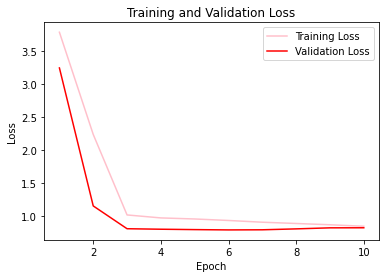

In [ ]:
# Draw the progress during the training
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# get instance for testing data
user_input_test, user_fea_test, item_input_test, item_fea_test, test_label = get_instances(testRatings, user_review_fea, item_review_fea)


In [ ]:
#evulate the test dataset
mean_absolute_error(model.predict([user_input_test, user_fea_test, item_input_test, item_fea_test]),test_label)

201/201 [==============================] - 1s 2ms/step


0.8263648

In [ ]:
mse=mean_squared_error(model.predict([user_input_test, user_fea_test, item_input_test, item_fea_test]),test_label)

201/201 [==============================] - 0s 2ms/step


In [ ]:
print(mse)

1.1724701


In [ ]:
rmse = math.sqrt(mse)

In [ ]:
print(rmse)

1.0828065814232186


In [ ]:
prediction = model.predict([user_input_test, user_fea_test, item_input_test, item_fea_test])

201/201 [==============================] - 0s 2ms/step


In [ ]:
dis = {1:0,2:0,3:0,4:0,5:0}
for i in  prediction.tolist() :
    if round(i[0]) in dis :
        dis[round(i[0])] +=1
    else :
        dis[1] +=1 
print(dis)
for i in range(1,6):
    dis[i]/=len(prediction)
print(dis)

{1: 13, 2: 0, 3: 365, 4: 4454, 5: 1592}
{1: 0.0020236612702366126, 2: 0.0, 3: 0.056818181818181816, 4: 0.6933374844333748, 5: 0.24782067247820672}


In [ ]:
label = {}
for i in test_label :
    if i in  label :
        label[i] += 1
    else :
        label[i] = 1 
for i in range(1,6):
    label[i]/=len(test_label)
print(label)

{5.0: 0.5541718555417185, 3.0: 0.11674968866749688, 4.0: 0.23100871731008718, 1.0: 0.04389788293897883, 2.0: 0.05417185554171856}


In [ ]:
plot =  {}
for i,j in  label.items() : 
    if i not in plot :
        plot[i] = [j]
    else :
        plto[i].append(j)
for i,j in dis.items() :
    plot[i].append(j)
plot = dict(sorted(plot.items() , key = lambda x:x[0]))

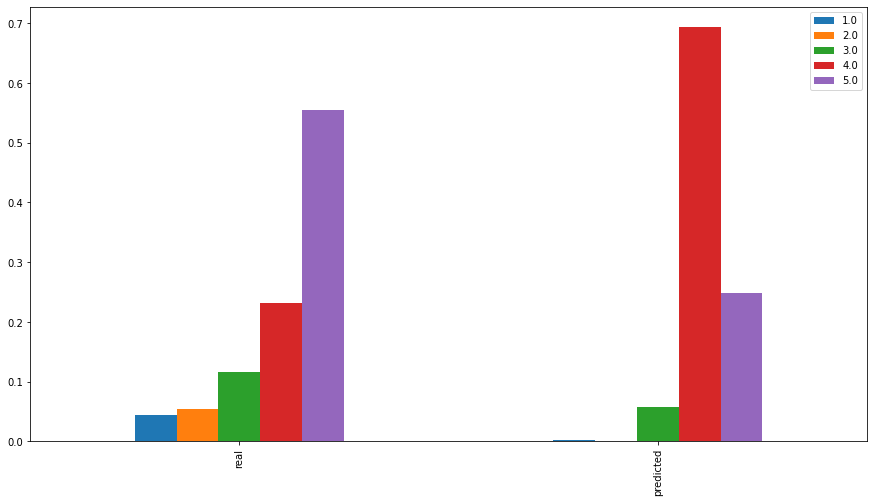

In [ ]:
frame  =  pd.DataFrame(plot , index = {"predicted","real"})
frame.plot(kind="bar",figsize=(15, 8))